In [1]:
import seaborn as sns
import pandas as pd
import numpy as np 
import re
pd.set_option('display.max_columns', 500)

In [2]:
#open csv, drop unnecessary columns
nba = pd.read_csv("../nba.csv")
nba = nba.drop(columns = ["Unnamed: 6", "Start (ET)","Notes","Unnamed: 7"])


In [3]:
#clean date and turn to date_time type
nba.Date = nba.Date.str.replace("^[A-z]{3}","-")
nba.Date.str.lstrip("- ")
nba.Date = nba.Date.str.replace(" ","-").str.lstrip("-")
nba.Date = pd.to_datetime(nba.Date)

In [4]:
#renaming columns
nba = nba.rename(columns = {"PTS":"AwayPTS", "PTS.1":"HomePTS", "Visitor/Neutral":"Away","Home/Neutral":"Home", "Attend.":"Attend"})

In [5]:
#creating homewins columns
nba["HomeWin"] = np.where(nba["HomePTS"] > nba["AwayPTS"], 1,0)


In [6]:
nbatest = nba[["Away","Home","HomeWin"]]

In [7]:
from sklearn import preprocessing
dummies = pd.get_dummies(nbatest[["Away","Home"]])
nbatest[dummies.columns] = dummies

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:3489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [8]:
nbatest = nbatest.drop(columns = ["Home","Away"])


In [9]:
#defining functions that check the accuracy score of our predictions using different models
#Random Forests
def RFscore(nbatest):
    X_train = nbatest[:900].drop(columns = "HomeWin")    
    y_train = nbatest["HomeWin"][:900]
    X_test = nbatest[900:].drop(columns = "HomeWin")
    y_test = nbatest["HomeWin"][900:]
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.datasets import make_classification
    mod = RandomForestClassifier(n_estimators = 100)
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test,y_pred)


#SVC
def SVCscore(nbatest):
    #train data/ test data
    X_train = nbatest[:900].drop(columns = "HomeWin")    
    y_train = nbatest["HomeWin"][:900]
    X_test = nbatest[900:].drop(columns = "HomeWin")
    y_test = nbatest["HomeWin"][900:]
    
    #fit model
    from sklearn.svm import SVC
    svc = SVC(gamma='auto')
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test,y_pred)


#LogisticRegression
def LRscore(nbatest):
    X_train = nbatest[:900].drop(columns = "HomeWin")    
    y_train = nbatest["HomeWin"][:900]
    X_test = nbatest[900:].drop(columns = "HomeWin")
    y_test = nbatest["HomeWin"][900:]
    
    from sklearn.linear_model import LogisticRegression
    mod = LogisticRegression()
    mod.fit(X_train,y_train)
    y_pred = mod.predict(X_test)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_test,y_pred)

In [10]:
#Adding "time on the road" feature
nbatest["Timeaway"] = 0
away_counts = {}
for i in nba["Away"].unique():
    away_counts[i] = 0
for i in range(len(nba.Away)):
    away_counts[nba.Away[i]] +=1
    away_counts[nba.Home[i]] = 0
    nbatest.iloc[i,-1] = away_counts[nba.Away[i]]

print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6393939393939394 
SVC Accuracy score: 0.5878787878787879 
Random Forests Accuracy score: 0.6181818181818182


In [11]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["Timeaway"]])
scaled = scaler.transform(nbatest[["Timeaway"]])
nbatest[["Timeaway"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6363636363636364 
SVC Accuracy score: 0.5909090909090909 
Random Forests Accuracy score: 0.6242424242424243


In [12]:
#adding Home win streak and Away win streak features
nbatest["HomeWinStreak"] = 0
nbatest["AwayWinStreak"] = 0
win_counts = {}
for i in nba["Away"].unique():
    win_counts[i] = 0
    
for row in range(len(nba)):
    if nbatest["HomeWin"][row] == 1:
        win_counts[nba["Home"][row]] +=1
        win_counts[nba["Away"][row]] == 0
    else:
        win_counts[nba["Away"][row]] +=1
        win_counts[nba["Home"][row]] == 0
    nbatest.iloc[row,-2] = win_counts[nba["Home"][row]]
    nbatest.iloc[row,-1] = win_counts[nba["Away"][row]]
    
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6909090909090909 
SVC Accuracy score: 0.6545454545454545 
Random Forests Accuracy score: 0.6424242424242425


In [13]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["HomeWinStreak","AwayWinStreak"]])
scaled = scaler.transform(nbatest[["HomeWinStreak","AwayWinStreak"]])
nbatest[["HomeWinStreak","AwayWinStreak"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6818181818181818 
SVC Accuracy score: 0.6848484848484848 
Random Forests Accuracy score: 0.6393939393939394


In [14]:
#adding Home lose streak and Away lose streak features
nbatest["HomeLoseStreak"] = 0
nbatest["AwayLoseStreak"] = 0
loss_counts = {}
for i in nba["Away"].unique():
    loss_counts[i] = 0
    

for row in range(len(nba)):
    if nbatest["HomeWin"][row] == 1:
        loss_counts[nba["Away"][row]] +=1
        loss_counts[nba["Home"][row]] == 0
    else:
        loss_counts[nba["Home"][row]] +=1
        loss_counts[nba["Away"][row]] == 0
    nbatest.iloc[row,-2] = loss_counts[nba["Home"][row]]
    nbatest.iloc[row,-1] = loss_counts[nba["Away"][row]]
    
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6818181818181818 
SVC Accuracy score: 0.6090909090909091 
Random Forests Accuracy score: 0.6454545454545455


In [15]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["HomeLoseStreak","AwayLoseStreak"]])
scaled = scaler.transform(nbatest[["HomeLoseStreak","AwayLoseStreak"]])
nbatest[["HomeLoseStreak","AwayLoseStreak"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6878787878787879 
SVC Accuracy score: 0.693939393939394 
Random Forests Accuracy score: 0.6333333333333333


In [16]:
nbatest["HomeCoachSavage"] = 0
nbatest["AwayCoachSavage"] = 0

nbatest.loc[nba["Home"]=="San Antonio Spurs","HomeCoachSavage"] = 6
nbatest.loc[nba["Home"]=="Boston Celtics","HomeCoachSavage"] = 5
nbatest.loc[nba["Home"]=="Golden State Warriors","HomeCoachSavage"] = 4
nbatest.loc[nba["Home"]=="Utah Jazz","HomeCoachSavage"] = 3
nbatest.loc[nba["Home"]=="Houston Rockets","HomeCoachSavage"] = 2
nbatest.loc[nba["Home"]=="Toronto Raptors","HomeCoachSavage"] = 1



nbatest.loc[nba["Away"]=="San Antonio Spurs","AwayCoachSavage"] = 6
nbatest.loc[nba["Away"]=="Boston Celtics","AwayCoachSavage"] = 5
nbatest.loc[nba["Away"]=="Golden State Warriors","AwayCoachSavage"] = 4
nbatest.loc[nba["Away"]=="Utah Jazz","AwayCoachSavage"] = 3
nbatest.loc[nba["Away"]=="Houston Rockets","AwayCoachSavage"] = 2
nbatest.loc[nba["Away"]=="Toronto Raptors","AwayCoachSavage"] = 1


print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6878787878787879 
SVC Accuracy score: 0.696969696969697 
Random Forests Accuracy score: 0.6303030303030303


In [17]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["HomeCoachSavage","AwayCoachSavage"]])
scaled = scaler.transform(nbatest[["HomeCoachSavage","AwayCoachSavage"]])
nbatest[["HomeCoachSavage","AwayCoachSavage"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6878787878787879 
SVC Accuracy score: 0.6848484848484848 
Random Forests Accuracy score: 0.6333333333333333


In [18]:
allstar_count = {}
for i in nba.Home.unique():
    allstar_count[i] = 0
allstar_count['Philadelphia 76ers'] = 2
allstar_count['Milwaukee Bucks'] = 2
allstar_count['Oklahoma City Thunder']=2
allstar_count['Golden State Warriors'] = 3
allstar_count['Denver Nuggets'] = 1
allstar_count['Detroit Pistons'] = 1
allstar_count['Brooklyn Nets'] = 1
allstar_count['Orlando Magic'] = 1
allstar_count['Toronto Raptors'] = 2
allstar_count['Dallas Mavericks'] = 1
allstar_count['Los Angeles Lakers'] = 1
allstar_count['Houston Rockets'] = 1
allstar_count['Orlando Magic'] = 1
allstar_count['Boston Celtics'] = 1
allstar_count['New Orleans Pelicans'] = 1
allstar_count[ 'Portland Trail Blazers'] = 1
allstar_count['San Antonio Spurs'] = 1
allstar_count['Minnesota Timberwolves'] = 1
allstar_count['Washington Wizards'] = 1
allstar_count['Miami Heat'] = 1


In [19]:
nbatest["HomeAllstars"] = 0
nbatest["AwayAllstars"] = 0
for i in range(len(nba)):
    nbatest.iloc[i,-1] = allstar_count[nba["Away"][i]]
    nbatest.iloc[i,-2] = allstar_count[nba["Home"][i]]


In [20]:
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6878787878787879 
SVC Accuracy score: 0.696969696969697 
Random Forests Accuracy score: 0.6424242424242425


In [21]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["HomeAllstars","AwayAllstars"]])
scaled = scaler.transform(nbatest[["HomeAllstars","AwayAllstars"]])
nbatest[["HomeAllstars","AwayAllstars"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6878787878787879 
SVC Accuracy score: 0.703030303030303 
Random Forests Accuracy score: 0.6545454545454545


In [23]:
score_dict = {}
for i in nba.Home.unique():
    score_dict[i] = {"counter" : 0, "totalscore" : 0}
score_dict["Miami Heat"]

{'counter': 0, 'totalscore': 0}

In [24]:
nbatest["AwayAvgScore"] = 0
nbatest["HomeAvgScore"] = 0
for i in range(len(nba)):
    #Home team counter and total score
    score_dict[nba.Home[i]]["counter"] +=1 
    score_dict[nba.Home[i]]["totalscore"] += nba.HomePTS[i]
    #Away team counter and score
    score_dict[nba.Away[i]]["counter"]+= 1 
    score_dict[nba.Away[i]]["totalscore"] += nba.AwayPTS[i]
    
    nbatest.iloc[i,-1] = score_dict[nba.Home[i]]["totalscore"] / score_dict[nba.Home[i]]["counter"]
    nbatest.iloc[i,-2] = score_dict[nba.Away[i]]["totalscore"] / score_dict[nba.Away[i]]["counter"]
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6787878787878788 
SVC Accuracy score: 0.6484848484848484 
Random Forests Accuracy score: 0.6484848484848484


In [25]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["AwayAvgScore","HomeAvgScore"]])
scaled = scaler.transform(nbatest[["AwayAvgScore","HomeAvgScore"]])
nbatest[["AwayAvgScore","HomeAvgScore"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression Accuracy Score:  0.6818181818181818 
SVC Accuracy score: 0.6848484848484848 
Random Forests Accuracy score: 0.6363636363636364


In [ ]:
sns.heatmap(nbatest["Timeaway"].corr()) 

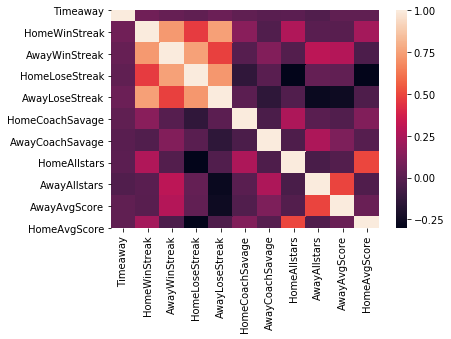

In [26]:
sns.heatmap(nbatest[['Timeaway', 'HomeWinStreak', 'AwayWinStreak',
       'HomeLoseStreak', 'AwayLoseStreak', 'HomeCoachSavage',
       'AwayCoachSavage', 'HomeAllstars', 'AwayAllstars', 'AwayAvgScore',
       'HomeAvgScore']].corr())

In [ ]:
#RANKINGS
#Creates dictionary with team and their rankings
feb_ranks = pd.read_csv("feb_ranks.csv")
feb_ranks["Team"] = feb_ranks["Western Conference"]
rankdict = {}
for i in range(len(feb_ranks.Team)):
    rankdict[feb_ranks.Team[i]] = feb_ranks.Rk[i]


In [ ]:
#Creates HomeRank and AwayRank for each matchup in nba dataset
nbatest["HomeRank"] = 0
nbatest["AwayRank"] = 0
for i in range(len(nbatest.HomeRank)):
    #Setting AwayRank for row i
    nbatest.iloc[i,-1] = rankdict[nba.Away[i]]
    #Setting HomeRank for row i
    nbatest.iloc[i,-2] = rankdict[nba.Home[i]]

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(nbatest[["HomeRank","AwayRank"]])
scaled = scaler.transform(nbatest[["HomeRank","AwayRank"]])
nbatest[["HomeRank","AwayRank"]]= scaled
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))


In [ ]:
#creates a single column that checks if the home team is ranked higher than away team 
rankspread = nbatest["HomeRank"]-nbatest["AwayRank"]
nbatest["HomeRanksHigher"]= 0
#if rankspread is positive, home is better
#if rankspread is negative, away is better
for i in range(len(nbatest)):
    if rankspread[i] > 0:
        nbatest.iloc[i,-1] = 1
    else:
        nbatest.iloc[i,-1] = 0
        

print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))

In [ ]:
#creates  a single column that checks if the home team is significantly better than the away team
rankspread = nbatest["HomeRank"]-nbatest["AwayRank"]

nbatest["HomeisFav"]= 0
for i in range(len(nbatest)):
    if rankspread[i] > 0 and rankspread[i] >5:
        nbatest.iloc[i,-1] = 1
    elif rankspread[i]<0 and abs(rankspread[i])>5:
        nbatest.iloc[i,-1] = 0
    else:
        nbatest.iloc[i,-1] = 0
nbatest.drop(columns = ["HomeRank","AwayRank"], inplace = True) 
print("Logistic Regression Accuracy Score: ",LRscore(nbatest),"\nSVC Accuracy score:",SVCscore(nbatest),"\nRandom Forests Accuracy score:",RFscore(nbatest))